In [ ]:
# Берём обученную модель и traindata
# выделяем данные с большой ошибкой, градации учим на всём датасете
# далее высокие ошибки так же разделяю на уровни
# строю на разбивке БС (начнём с дискретной, можно потом проработать гибридную)
# на БС надо наложить условия (?), только входящие/исходящие рёбра (узнать, какая будет разница)
# получаю БС, могу теперь проводить анализ по типу "как выглядят данные, если выбрать самые высокие ошибки" и т.д.
# тут либо остановиться на этом (выделять интереующие градации предикторов как аргмакс), либо рассмотреть все градации больших ошибок, выделить аргмаксы и либо выбрать общее, либо взвесить в зависимости от уровня высокой ошибки 

In [1]:
import os

import sys
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN\\src")
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN")
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN\\venv")

path = os.getcwd()

curr_path = path.replace('\\', '/')
head_place = curr_path.find('GIEBN')
main_path = curr_path[:head_place]+'GIEBN'
main_path

'c:/Users/User/PycharmProjects/GIEBN'

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, make_union
from sklearn.datasets import make_regression

from auxiliary.auxiliary import construct_by_kmeans
from pgmpy.estimators import K2Score
from bamt.networks.discrete_bn import DiscreteBN
from bamt_inherited.networks.discrete import DiscreteBNGI
import shap

from tqdm import tqdm

imagespath = 'C://Users/User/PycharmProjects/GIEBN/experiments/shaplime/images'

In [3]:
data = pd.read_csv("../../datasets/Bike_Sharing_Demand.csv")

n = data.shape[0]
target = "count"
features = ['feel_temp', 'humidity', 'windspeed']
data = data[features+[target]]
n_features = len(features)
data.head(10)

,feel_temp,humidity,windspeed,count
0,14.395,0.81,0.0000,16.0
1,13.635,0.80,0.0000,40.0
2,13.635,0.80,0.0000,32.0
3,14.395,0.75,0.0000,13.0
4,14.395,0.75,0.0000,1.0
5,12.880,0.75,6.0032,1.0
6,13.635,0.80,0.0000,2.0
7,12.880,0.86,0.0000,3.0
8,14.395,0.75,0.0000,8.0
9,17.425,0.76,0.0000,14.0


In [4]:
%run ../common_code.ipynb

In [5]:
model = GradientBoostingRegressor(n_estimators=30,)
#model = LinearRegression()
model.fit(data[features], data[target])

GradientBoostingRegressor(n_estimators=30)

In [6]:
data_errors = data.copy(deep=True)
data_errors["ape_error"] = np.abs((data[target]-model.predict(data[features]))/data[target])
data_errors.drop(columns=[target], inplace=True)
data_errors.head()

,feel_temp,humidity,windspeed,ape_error
0,14.395,0.81,0.0,4.644600
1,13.635,0.80,0.0,1.046492
2,13.635,0.80,0.0,1.558115
3,14.395,0.75,0.0,5.947200
4,14.395,0.75,0.0,89.313595


In [7]:
data_disc, tfdata = discretize(data_errors, data_errors.columns, icat=None, icont=list(range(n_features)),
                               contdiscstrategy="quantile")

In [8]:
for feat in data_disc.columns:
    print(feat, data_disc[feat].value_counts())

feel_temp feel_temp
2    6049
1    5865
0    5465
Name: count, dtype: int64
humidity humidity
2    6075
0    5736
1    5568
Name: count, dtype: int64
windspeed windspeed
2    7067
0    5222
1    5090
Name: count, dtype: int64
ape_error ape_error
2    5793
1    5793
0    5793
Name: count, dtype: int64


In [9]:
data_he = data_errors[data_disc['ape_error']==2]
data_he_disc = data_disc[data_disc['ape_error']==2]
data_he

,feel_temp,humidity,windspeed,ape_error
0,14.395,0.81,0.0000,4.644600
2,13.635,0.80,0.0000,1.558115
3,14.395,0.75,0.0000,5.947200
4,14.395,0.75,0.0000,89.313595
5,12.880,0.75,6.0032,76.185393
...,...,...,...,...
17356,9.090,0.55,12.9980,3.620588
17357,8.335,0.59,11.0014,6.588691
17358,9.090,0.59,7.0015,83.788917
17359,8.335,0.69,7.0015,23.315184


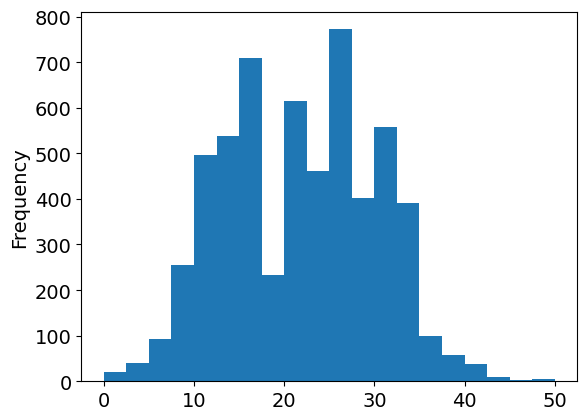

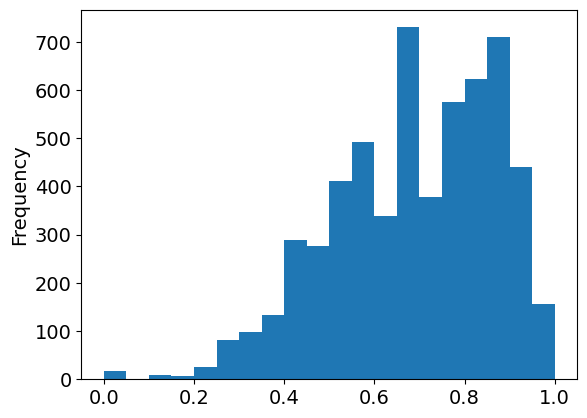

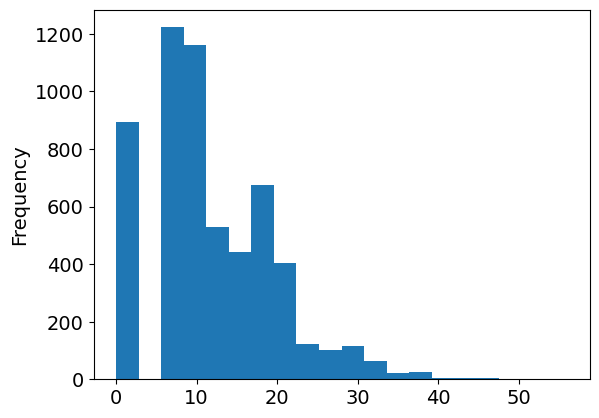

In [10]:
for feat in features:
    plt.figure()
    data_he[feat].plot(kind='hist', bins=20)

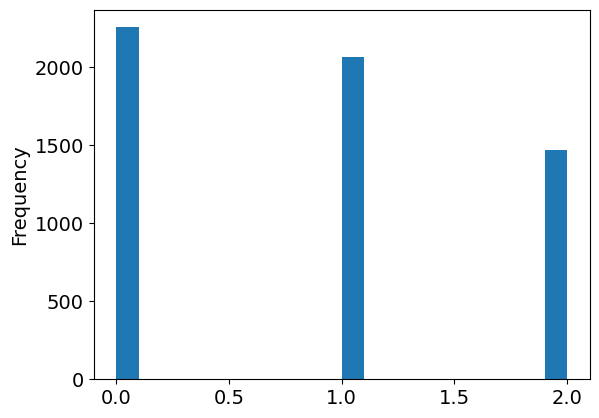

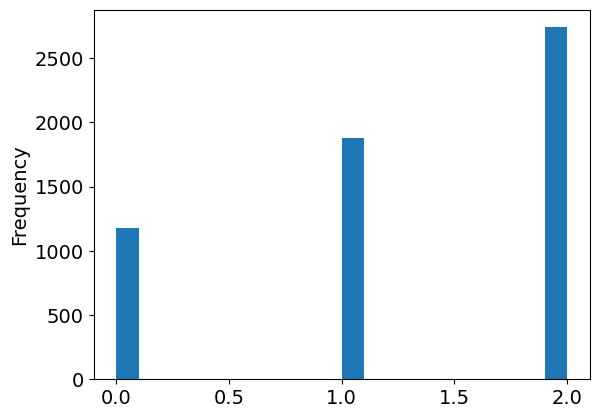

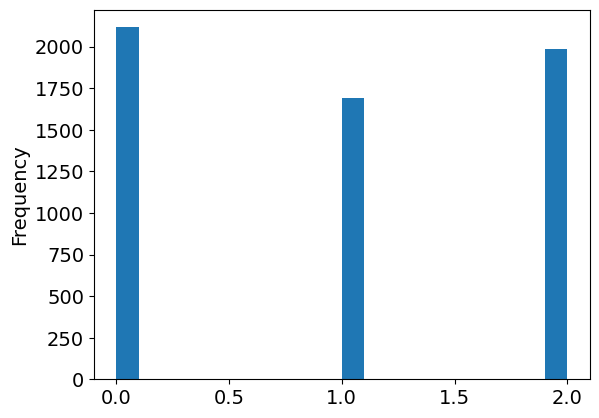

In [11]:
for feat in features:
    plt.figure()
    data_he_disc[feat].plot(kind='hist', bins=20)

In [12]:
data_he_disc_error = pd.qcut(data_he['ape_error'], q=3, labels=[0,1,2])
#data_he_disc_error
data_he_disc['ape_error_2'] = data_he_disc_error

In [118]:
data_he_disc.columns

Index(['feel_temp', 'humidity', 'windspeed', 'ape_error', 'ape_error_2'], dtype='object')

In [13]:
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.models import BayesianNetwork
import yodo.yodo
import matplotlib.pyplot as plt
from pgmpy.estimators import PC, BicScore

In [14]:
bn = DiscreteBN()
bn.add_nodes({"types": {feat: "disc" for feat in features+['ape_error_2']}})

blacklist = [(x, "ape_error_2") for x in features]

In [15]:
bn.add_edges(data_he_disc[features+['ape_error_2']], scoring_function=("K2", BicScore), params={"bl_add": blacklist})

2025-03-20 20:01:41,980 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: category


  0%|          | 0/1000000 [00:00<?, ?it/s]

In [16]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,ape_error_2,Discrete,disc,[],[]
1,humidity,Discrete,disc,[ape_error_2],[disc]
2,feel_temp,Discrete,disc,"[humidity, ape_error_2]","[disc, disc]"
3,windspeed,Discrete,disc,[humidity],[disc]


In [17]:
bn.fit_parameters(data=data_he_disc[features+['ape_error_2']], n_jobs=1)

In [18]:
bn.plot(output='abc1.html')

In [19]:
bn.distributions['humidity']

{'cprob': {"['1']": [0.15018125323666495,
   0.31641636457793887,
   0.5334023821853962],
  "['0']": [0.3174520973588814, 0.30243397203521494, 0.38011393060590365],
  "['2']": [0.14344899016053858, 0.3516312791299845, 0.5049197307094769]},
 'vals': ['0', '1', '2']}

In [20]:
bn.get_dist('humidity', {'ape_error_2': '2'})

[0.14344899016053858, 0.3516312791299845, 0.5049197307094769]

In [23]:
bn.get_dist('feel_temp', {'ape_error_2': '2', 'humidity': '0'})

[0.6787003610108303, 0.23826714801444043, 0.08303249097472924]

In [24]:
bn.get_dist('feel_temp', {'ape_error_2': '2', 'humidity': '1'})

[0.4801178203240059, 0.2812960235640648, 0.23858615611192932]

In [25]:
bn.get_dist('feel_temp', {'ape_error_2': '2', 'humidity': '2'})

[0.29333333333333333, 0.4461538461538462, 0.2605128205128205]

In [26]:
from copy import copy
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_percentage_error as mape

In [27]:
d_dict={
    'bn': [['humidity', 'feel_temp'], [2, 1]],
}

In [93]:
n

17379

In [28]:
pipeline_data=tfdata

In [29]:
np.random.seed(42)

stats_res = bootstrap_sampling(data, d_dict, n,
                                    [mape, 
                                    r2_score], trials=50,alpha=0.9, incl_random_removal=True,
                                    drop_mode='metric',
                                    mode='regr',
                                    incl_test=True,
                                    test_size=0.25,
                                    stratify_tts=False)

100%|██████████| 50/50 [00:54<00:00,  1.09s/it]


In [31]:
def plot_scores(metrics, labels, graph_label, k):
    for name in metrics.keys():
        sns.histplot(metrics[name][k], label=names_mapping[name], bins=25)
        print(f'name: {name}', sum(metrics[name][k])/len(metrics[name][k]))
    plt.legend()
    plt.xlabel(graph_label)

names_mapping = {k:v for k, v in
                        zip(['init', 'yodo', 'bn', 'shap', 'random'],
                        ["Before elimination",
                          "YODO",
                          "gradation BN",
                          "SHAP",
                          "random"
                          ])}

In [97]:
%run ../common_code.ipynb

name: bn 5.181660780185289
name: init 4.935202044682761
name: random 4.931636697279238
name: bn 0.29532267569794113
name: init 0.29925810185797214
name: random 0.29948000343371173


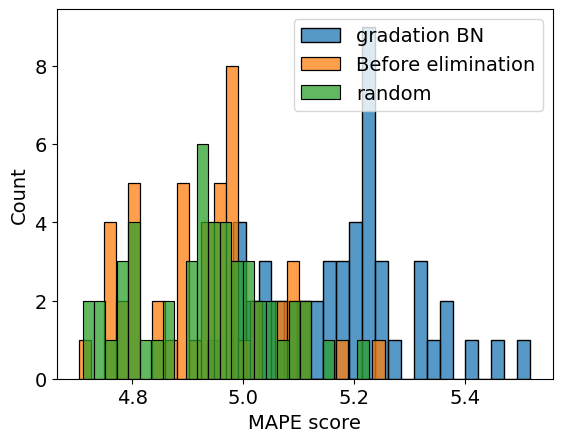

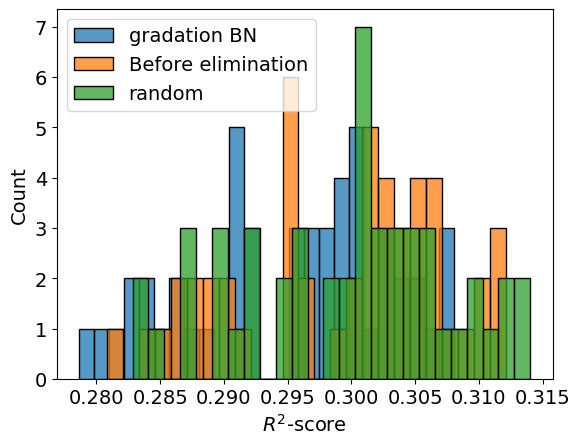

In [32]:
for k, label in enumerate(['MAPE score', '$R^2$-score']):
    plt.figure()
    plot_scores(stats_res['metrics'], ["Before elimination",
                          "gradation BN",
                          "random"
                          ], label, k)

In [ ]:
# что если удалять наблюдения, где факторы ведут к низкой ошибке
# А наблюдения, ведущие к высокой, добавлять? 
# при этом нас скорее уже интересует качество модели на отложенной выборке, т.к. качество на выборке разработки 
# явно будет ухудшаться
# в первом случае мы пытаемся улучшить обобщ способность
# во втором -- помочь модели подстроиться под данные, которые она предсказывает хуже
# во втором случае можем делать оверсамплинг известными методами (где метка класса -- флажок наблюдений, которые хотим рахмножить)
# либо оверсамплинг через БС с обуславливанием (evidence), наверное

name: bn 4.979977359960281
name: init 4.992700580213491
name: random 4.990238102812635
name: bn 0.2855481407507108
name: init 0.285172445820635
name: random 0.28516563532762196


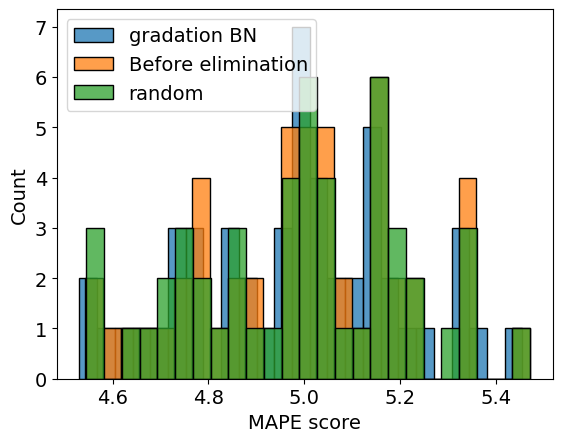

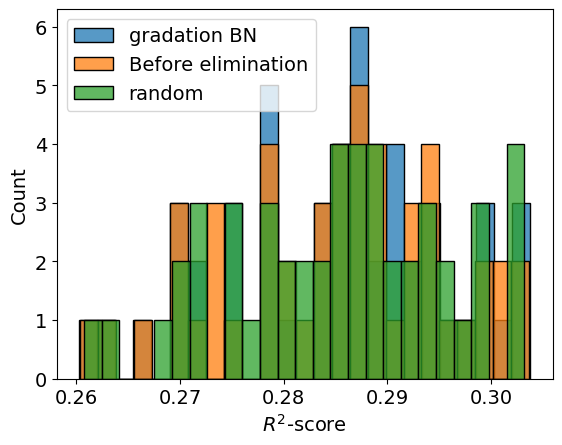

In [33]:
for k, label in enumerate(['MAPE score', '$R^2$-score']):
    plt.figure()
    plot_scores(stats_res['metrics_test'], ["Before elimination",
                          "gradation BN",
                          "random"
                          ], label, k)

Итого: удаление части наблюдений с низкой высокой ошибкой помогло в улучшении качества модели на тестовой выборке

In [ ]:
bn.

In [7]:
data_disc, tfdata = discretize(data, features, icat=None, icont=list(range(n_features)))

In [ ]:
data_disc[]

In [112]:
explainer = shap.Explainer(model)
shap_values = explainer(data_he.reset_index()[data_he_disc['ape_error_2']==0][features])
shap.plots.beeswarm(shap_values)
# смотрим на наблюдения с высокой ошибкой -- по ним самый влиятельный фактор такой-то, он чаще приводит к непопаданию в значение

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [113]:
data_he

,feel_temp,humidity,windspeed,ape_error
0,14.395,0.81,0.0000,4.644600
2,13.635,0.80,0.0000,1.558115
3,14.395,0.75,0.0000,5.947200
4,14.395,0.75,0.0000,89.313595
5,12.880,0.75,6.0032,76.185393
...,...,...,...,...
17356,9.090,0.55,12.9980,3.620588
17357,8.335,0.59,11.0014,6.588691
17358,9.090,0.59,7.0015,83.788917
17359,8.335,0.69,7.0015,23.315184
